In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer, ModeClusterer_HDBSCAN  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [37]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"

save = False
load = True
get_meteo = False

if save:
    dsg = DatasetGetter(start, stop, location)
    dsg.get_longterm_data()
    dsg.save_data(data_path)

if load:
    data = pd.read_parquet(data_path)

if get_meteo:
    data = pd.read_parquet(data_path)
    # GET METEO DATA
    weather_station = 'Wandelaar - Measuring pile'
    mvbc_username = os.getenv('MEETNET_USERNAME') # Replace with your usernam
    mvbc_password = os.getenv('MEETNET_PASSWORD') # Replace with your password
    creds = Credentials(username=mvbc_username, password=mvbc_password)
    b=Base(creds)
    b.ping()

    c = Catalog(credentials=creds)
    df_unfiltered = c.data_points()
    weather_station_data_LAT = \
        dg.get_data_by_weatherstation(
            weather_station,
            start,
            stop,
            creds,
            df_unfiltered
        )
    weather_station_data_LAT = weather_station_data_LAT.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)
    weather_station_data_LAT.reindex(data.index, method='nearest').interpolate(method='linear')
    weather_station_data_LAT.to_parquet("../../data/nw2/mvbc_data.parquet")

In [4]:
rated_data = get_rated_data(data)
parked_data = get_parked_data(data)

In [5]:
mpe_data = data.filter(regex='mpe')
mpe_FA = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().index
        )
mpe_SS = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().index
        )

In [6]:
def select_max_row(data, selection_column):
    """
    Selects the row with the highest value of a specific column when the index is duplicated in a dataframe.
    :param data: The dataframe to select rows from.
    :param selection_column: The name of the column to select the maximum of.
    :return: A dataframe with the selected rows.
    """
    max_rows = data.groupby(data.index).apply(lambda x: x.loc[x[selection_column].idxmax()])
    return max_rows

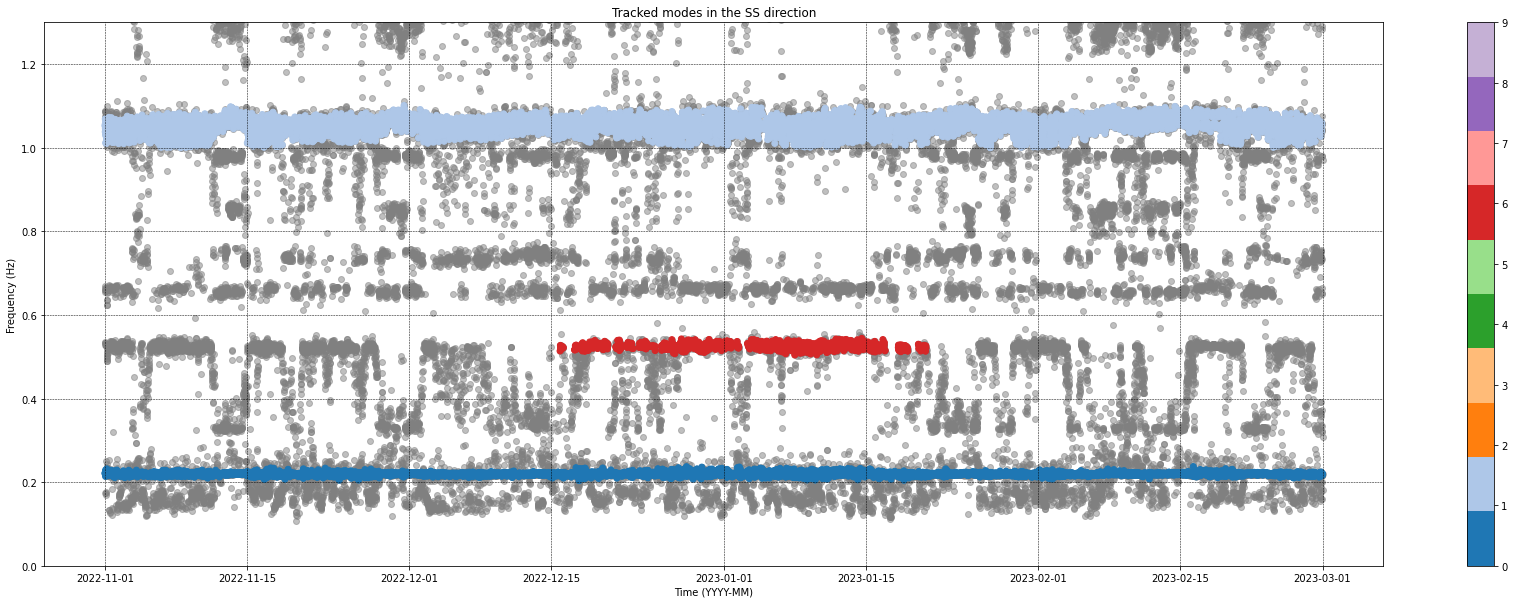

In [7]:
mc = ModeClusterer(
    eps = 4,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 1, "damping": 1},
    index_divider = 1000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data = mpe_SS.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc.fit(clustering_data)
clustered_modes = mc.predict(min_cluster_size=1000)

fig = plt.figure(figsize = (30,10))
plt.scatter(clustering_data.index, clustering_data['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)
plt.show()
SS1 = clustered_modes[clustered_modes.labels == 0]
SS1 = SS1[~SS1.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)
SS2 = clustered_modes[clustered_modes.labels == 1]
SS2 = SS2[~SS2.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)

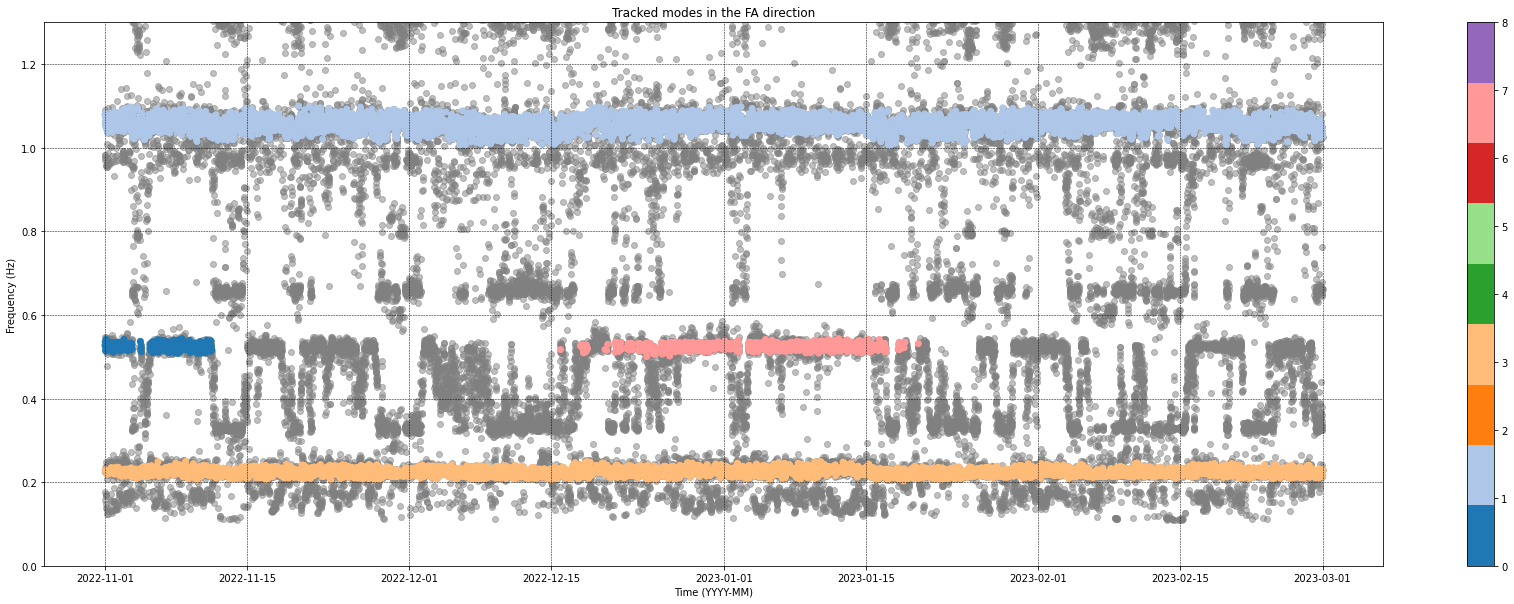

In [8]:
mc = ModeClusterer(
    eps = 5,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 2, "damping": 2},
    index_divider = 1200,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data = mpe_FA.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc.fit(clustering_data)
clustered_modes = mc.predict(min_cluster_size=500)

fig = plt.figure(figsize = (30,10))
plt.scatter(clustering_data.index, clustering_data['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the FA direction')
plt.ylim(0, 1.3)
plt.show()
FA1 = clustered_modes[clustered_modes.labels == 3]
FA1 = FA1[~FA1.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)
FA2 = clustered_modes[clustered_modes.labels == 1]
FA2 = FA2[~FA2.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)

In [9]:
tracked_frequencies = \
    pd.DataFrame(
        {
            'SS1': SS1['frequency'],
            'SS2': SS2['frequency'],
            'FA1': FA1['frequency'],
            'FA2': FA2['frequency'],
        }
    )

In [10]:
tracked_frequencies.to_parquet('../../data/nw2/tracked_modes/' + location + '.parquet', compression='gzip')

In [11]:
tracked_frequencies = pd.read_parquet('../../data/nw2/tracked_modes/' + location + '.parquet')

# PLaying around with HDBSCAN

In [34]:
hdbscan_hyperparameters = {
        'min_cluster_size': 500,
        'cluster_selection_epsilon': 0,
        'multipliers': {"frequency": 100, "size": 0.5, "damping": 1},
        'index_divider': 10000,
        'cols': ['frequency', 'size', 'damping'],
        'min_size': 5.0,
        'max_damping': 5.0,
        'min_samples': 500
    }
mc = ModeClusterer_HDBSCAN(
    min_cluster_size = hdbscan_hyperparameters['min_cluster_size'],
    cluster_selection_epsilon = hdbscan_hyperparameters['cluster_selection_epsilon'],
    multipliers = hdbscan_hyperparameters['multipliers'],
    index_divider = hdbscan_hyperparameters['index_divider'],
    cols = hdbscan_hyperparameters['cols'],
    min_size = hdbscan_hyperparameters['min_size'],
    max_damping = hdbscan_hyperparameters['max_damping']
    )
culstering_data = mpe_FA.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})

mc.fit(culstering_data, min_samples=hdbscan_hyperparameters['min_samples'])
clustered_modes = mc.predict(min_cluster_size=350)

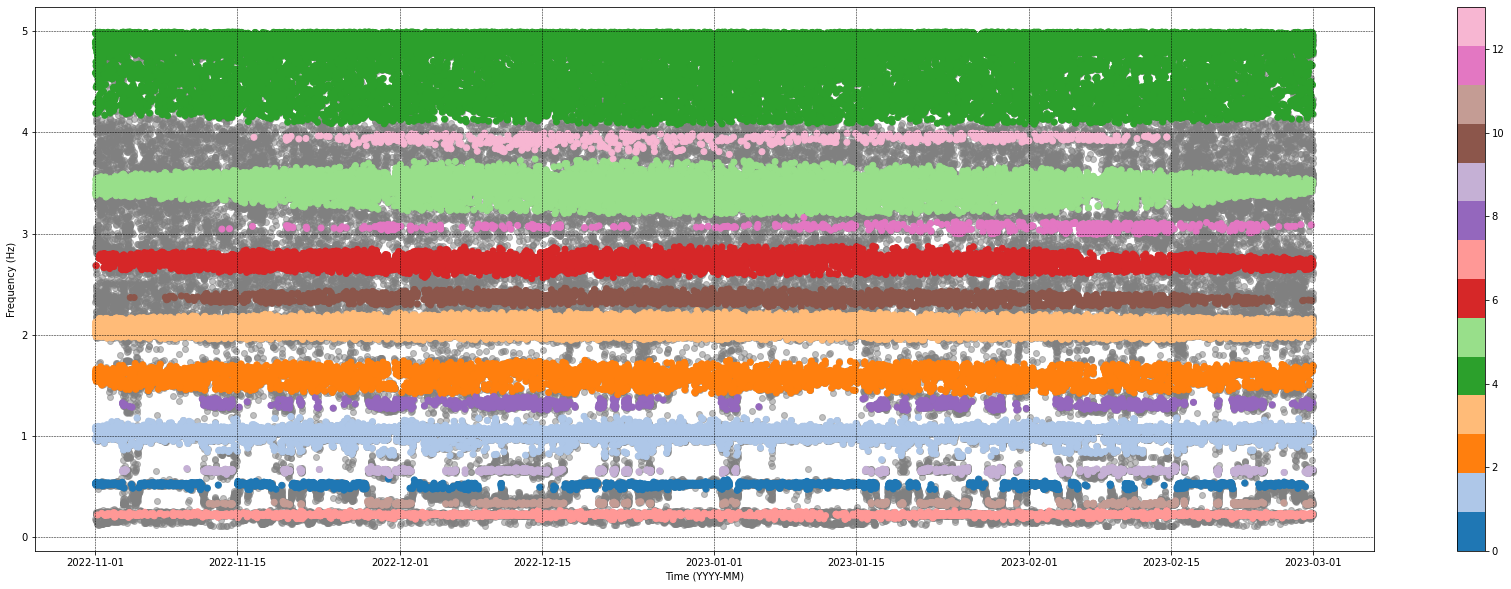

In [35]:
fig = plt.figure(figsize = (30,10))
plt.scatter(culstering_data.index, culstering_data['frequency'], alpha=0.5, color='grey')

tab = plt.get_cmap('tab20')
first_colors = tab(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
#plt.title('Tracked modes in the Z (SS) direction')
plt.show()

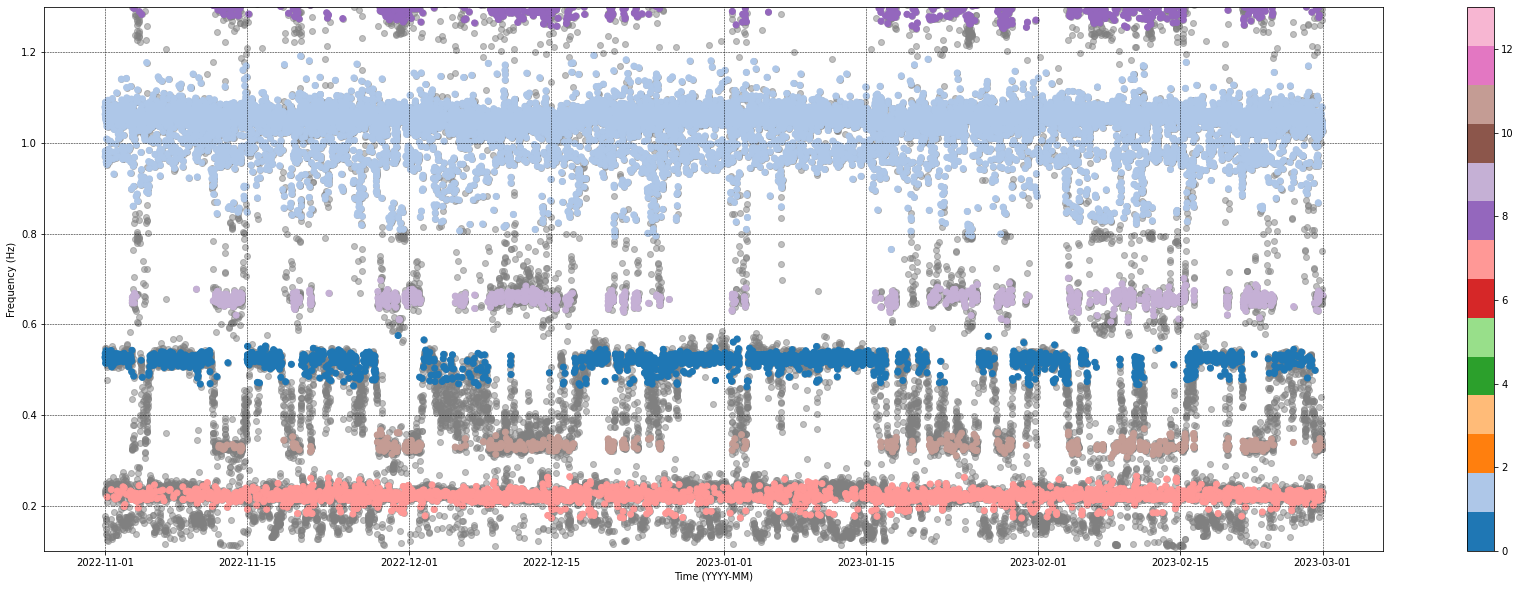

In [36]:
fig = plt.figure(figsize = (30,10))
plt.scatter(culstering_data.index, culstering_data['frequency'], alpha=0.5, color='grey')

tab = plt.get_cmap('tab20')
first_colors = tab(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0.1, 1.3)
#plt.title('Tracked modes in the Z (SS) direction')
plt.show()

In [ ]:
mch_plots = ModeClusterer_HDBSCAN(
    min_cluster_size = hdbscan_hyperparameters['min_cluster_size'],
    multipliers = hdbscan_hyperparameters['multipliers'],
    index_divider = hdbscan_hyperparameters['index_divider'],
    cols = hdbscan_hyperparameters['cols'],
    min_size = hdbscan_hyperparameters['min_size'],
    max_damping = hdbscan_hyperparameters['max_damping']
    )
culstering_data_plots = \
    mpe_FA.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})\
        .loc[datetime.datetime(2022,11,1, tzinfo=utc):datetime.datetime(2022,11,7, tzinfo=utc)]

mch_plots.fit(culstering_data_plots)
clustered_modes_plot = mc.predict(min_cluster_size=10)
plt.figure(figsize=(30,10))
mch_plots.dbsc.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

: 

: 

<AxesSubplot:ylabel='$\\lambda$ value'>

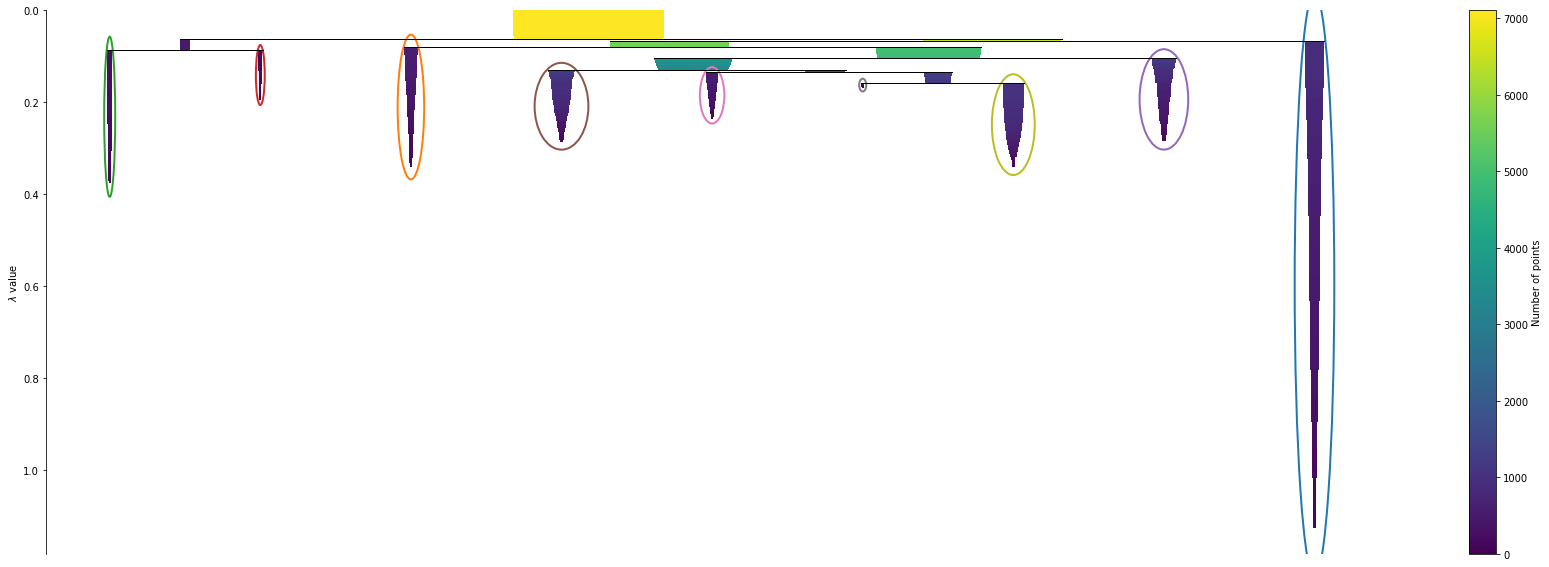

In [ ]:
plt.figure(figsize=(30,10))
mch_plots.dbsc.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())